<a href="https://colab.research.google.com/github/AdebanjiAdelowo/Other-projects/blob/main/FellowshipAiChallenge_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VOC Image Classification


## Introduction

The main goal of this challenge is to recognize objects from a number of visual object classes in realistic scenes (i.e. not pre-segmented objects). It is fundamentally a supervised learning learning problem in that a training set of labelled images is provided. The twenty object classes that have been selected are:

1.   Person: person
2.   Animal: bird, cat, cow, dog, horse, sheep
3.   Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
4.   Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

There are three main object recognition competitions: classification, detection, and segmentation. In this work we will focus on the classification problem.

*  Classification: For each of the twenty classes, predicting presence/absence of an example of that class in the test image.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls "/content/gdrive/My Drive/pascal12/models/resnet18"

accuracy-1.png		log-1.txt   model-1.pth
clf_vs_threshold-1.png	log-2.txt   scores-1.csv
gt-1.csv		loss-1.png  scores_wth_gt-1.csv


In [3]:
# Necessary imports

import os
import math
import torch
import gc
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score
from torchvision import transforms
import torchvision.models as  models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.utils.model_zoo as model_zoo

## Dataset

We will use Pascal VOC 2012 dataset for this project and the latest version of pytorch has Pascal VOC dataset class built-in. The VOC2012 data is released in two phases: (i) training and validation data
with annotation is released with this development kit; (ii) test data without
annotation is released at a later date.

**Classification/Detection Image Sets**

For the classification and detection tasks there are four sets of images provided:
*   train: Training data
*   val: Validation data (suggested). The validation data may be used as additional training data (see below).
* trainval: The union of train and val.

* test: Test data. The test set is not provided in the development kit. 

Since pytorch has the Pascal VOC dataset class built-in. We create our dataset class by inheriting from the pytorch Pascal VOC dataset class as shown below.


In [4]:
import torchvision.datasets.voc as voc

class PascalVOC_Dataset(voc.VOCDetection):
    """`Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Detection Dataset.
        Args:
            root (string): Root directory of the VOC Dataset.
            year (string, optional): The dataset year, supports years 2007 to 2012.
            image_set (string, optional): Select the image_set to use, ``train``, ``trainval`` or ``val``
            download (bool, optional): If true, downloads the dataset from the internet and
                puts it in root directory. If dataset is already downloaded, it is not
                downloaded again.
                (default: alphabetic indexing of VOC's 20 classes).
            transform (callable, optional): A function/transform that  takes in an PIL image
                and returns a transformed version. E.g, ``transforms.RandomCrop``
            target_transform (callable, required): A function/transform that takes in the
                target and transforms it.
    """
    def __init__(self, root, year='2012', image_set='train', download=False, transform=None, target_transform=None):
        
        super().__init__(root, year=year, image_set=image_set, download=download, transform=transform, target_transform=target_transform)
    
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
    
        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        return super().__getitem__(index)
        
    
    def __len__(self):
        """
        Returns:
            size of the dataset
        """
        return len(self.images)

## Loss function

The task is multi-label classification for 20 object classes, which is analogous to creating 20 object detectors, 1 for every class. Hence we have used binary cross entropy (with logits loss) as our loss function.

In pytorch, the loss function is **torch.nn.BCEWithLogitsLoss( )**. Do note that this function provides numerical stability over the sequence of sigmoid followed by binary cross entropy. The loss function is clearly documented 
[here](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#BCEWithLogitsLoss)


## Metrics

We used average precision as the metric to measure performance. It is simply the average of the maximum precisions at different recall values.

Accuracy is a very poor metric to be used in this problem. I.e.: In a picture containing a person and dog, the model can output the result as train and get away with an accuracy of 85%!

## Some Important Utility Functions

In [5]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']


def get_categories(labels_dir):
    """
    Get the object categories
    
    Args:
        label_dir: Directory that contains object specific label as .txt files
    Raises:
        FileNotFoundError: If the label directory does not exist
    Returns:
        Object categories as a list
    """
    
    if not os.path.isdir(labels_dir):
        raise FileNotFoundError
    
    else:
        categories = []
        
        for file in os.listdir(labels_dir):
            if file.endswith("_train.txt"):
                categories.append(file.split("_")[0])
        
        return categories


def encode_labels(target):
    """
    Encode multiple labels using 1/0 encoding 
    
    Args:
        target: xml tree file
    Returns:
        torch tensor encoding labels as 1/0 vector
    """
    
    ls = target['annotation']['object']
  
    j = []
    if type(ls) == dict:
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))
  
    else:
        for i in range(len(ls)):
            if int(ls[i]['difficult']) == 0:
                j.append(object_categories.index(ls[i]['name']))
    
    k = np.zeros(len(object_categories))
    k[j] = 1
  
    return torch.from_numpy(k)


def get_nrows(file_name):
    """
    Get the number of rows of a csv file
    
    Args:
        file_path: path of the csv file
    Raises:
        FileNotFoundError: If the csv file does not exist
    Returns:
        number of rows
    """
    
    if not os.path.isfile(file_name):
        raise FileNotFoundError
    
    s = 0
    with open(file_name) as f:
        s = sum(1 for line in f)
    return s


def get_mean_and_std(dataloader):
    """
    Get the mean and std of a 3-channel image dataset 
    
    Args:
        dataloader: pytorch dataloader
    Returns:
        mean and std of the dataset
    """
    mean = []
    std = []
    
    total = 0
    r_running, g_running, b_running = 0, 0, 0
    r2_running, g2_running, b2_running = 0, 0, 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            r, g, b = data[:,0 ,:, :], data[:, 1, :, :], data[:, 2, :, :]
            r2, g2, b2 = r**2, g**2, b**2
            
            # Sum up values to find mean
            r_running += r.sum().item()
            g_running += g.sum().item()
            b_running += b.sum().item()
            
            # Sum up squared values to find standard deviation
            r2_running += r2.sum().item()
            g2_running += g2.sum().item()
            b2_running += b2.sum().item()
            
            total += data.size(0)*data.size(2)*data.size(3)
    
    # Append the mean values 
    mean.extend([r_running/total, 
                 g_running/total, 
                 b_running/total])
    
    # Calculate standard deviation and append
    std.extend([
            math.sqrt((r2_running/total) - mean[0]**2),
            math.sqrt((g2_running/total) - mean[1]**2),
            math.sqrt((b2_running/total) - mean[2]**2)
            ])
    
    return mean, std


def plot_history(train_hist, val_hist, y_label, filename, labels=["train", "validation"]):
    """
    Plot training and validation history
    
    Args:
        train_hist: numpy array consisting of train history values (loss/ accuracy metrics)
        valid_hist: numpy array consisting of validation history values (loss/ accuracy metrics)
        y_label: label for y_axis
        filename: filename to store the resulting plot
        labels: legend for the plot
        
    Returns:
        None
    """
    # Plot loss and accuracy
    xi = [i for i in range(0, len(train_hist), 2)]
    plt.plot(train_hist, label = labels[0])
    plt.plot(val_hist, label = labels[1])
    plt.xticks(xi)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.savefig(filename)
    plt.show()


def get_ap_score(y_true, y_scores):
    """
    Get average precision score between 2 1-d numpy arrays
    
    Args:
        y_true: batch of true labels
        y_scores: batch of confidence scores
=
    Returns:
        sum of batch average precision
    """
    scores = 0.0
    
    for i in range(y_true.shape[0]):
        scores += average_precision_score(y_true = y_true[i], y_score = y_scores[i])
    
    return scores

def save_results(images, scores, columns, filename):
    """
    Save inference results as csv
    
    Args:
        images: inferred image list
        scores: confidence score for inferred images
        columns: object categories
        filename: name and location to save resulting csv
    """
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['image'] = images
    df_scores.set_index('image', inplace=True)
    df_scores.to_csv(filename)


def append_gt(gt_csv_path, scores_csv_path, store_filename):
    """
    Append ground truth to confidence score csv
    
    Args:
        gt_csv_path: Ground truth csv location
        scores_csv_path: Confidence scores csv path
        store_filename: name and location to save resulting csv
    """
    gt_df = pd.read_csv(gt_csv_path)
    scores_df = pd.read_csv(scores_csv_path)
    
    gt_label_list = []
    for index, row in gt_df.iterrows():
        arr = np.array(gt_df.iloc[index,1:], dtype=int)
        target_idx = np.ravel(np.where(arr == 1))
        j = [object_categories[i] for i in target_idx]
        gt_label_list.append(j)
    
    scores_df.insert(1, "gt", gt_label_list)
    scores_df.to_csv(store_filename, index=False)


def get_classification_accuracy(gt_csv_path, scores_csv_path, store_filename):

    """
    Plot mean tail accuracy across all classes for threshold values
    
    Args:
        gt_csv_path: Ground truth csv location
        scores_csv_path: Confidence scores csv path
        store_filename: name and location to save resulting plot
    """
  
    gt_df = pd.read_csv(gt_csv_path)
    
    scores_df = pd.read_csv(scores_csv_path)
    
    # Get the top-50 images
    top_num = 2800
    image_num = 2
    num_threshold = 10
    results = []
    
    for image_num in range(1, 21):
        clf = np.sort(np.array(scores_df.iloc[:,image_num], dtype=float))[-top_num:]
        ls = np.linspace(0.0, 1.0, num=num_threshold)
        
        class_results = []
        for i in ls:
            clf = np.sort(np.array(scores_df.iloc[:,image_num], dtype=float))[-top_num:]
            clf_ind = np.argsort(np.array(scores_df.iloc[:,image_num], dtype=float))[-top_num:]
            
            # Read ground truth
            gt = np.sort(np.array(gt_df.iloc[:,image_num], dtype=int))
            
            # Now get the ground truth corresponding to top-50 scores
            gt = gt[clf_ind]
            clf[clf >= i] = 1
            clf[clf < i] = 0
            
            score = accuracy_score(y_true=gt, y_pred=clf, normalize=False)/clf.shape[0]
            class_results.append(score)
        
        results.append(class_results)
    
    results = np.asarray(results)
    
    ls = np.linspace(0.0, 1.0, num=num_threshold)
    plt.plot(ls, results.mean(0))
    plt.title("Mean Tail Accuracy vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Mean Tail Accuracy")
    plt.savefig(store_filename)
    plt.show()    

# Training Model Function

In [6]:
def train_model(model, device, optimizer, scheduler, train_loader, valid_loader, save_dir, model_num, epochs, log_file):
    """
    Train a deep neural network model
    
    Args:
        model: pytorch model object
        device: cuda or cpu
        optimizer: pytorch optimizer object
        scheduler: learning rate scheduler object that wraps the optimizer
        train_dataloader: training  images dataloader
        valid_dataloader: validation images dataloader
        save_dir: Location to save model weights, plots and log_file
        epochs: number of training epochs
        log_file: text file instance to record training and validation history
        
    Returns:
        Training history and Validation history (loss and average precision)
    """
    
    tr_loss, tr_map = [], []
    val_loss, val_map = [], []
    best_val_map = 0.0
    
    # Each epoch has a training and validation phase
    for epoch in range(epochs):
        print("-------Epoch {}----------".format(epoch+1))
        log_file.write("Epoch {} >>".format(epoch+1))
        scheduler.step()
        
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_ap = 0.0
            
            criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
            m = torch.nn.Sigmoid()
            
            if phase == 'train':
                model.train(True)  # Set model to training mode
                
                for data, target in tqdm(train_loader):
                    #print(data)
                    target = target.float()
                    data, target = data.to(device), target.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    output = model(data)
                    
                    loss = criterion(output, target)
                    
                    # Get metrics here
                    running_loss += loss # sum up batch loss
                    running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
               
                    # Backpropagate the system the determine the gradients
                    loss.backward()
                    
                    # Update the paramteres of the model
                    optimizer.step()
            
                    # clear variables
                    del data, target, output
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    #print("loss = ", running_loss)
                    
                num_samples = float(len(train_loader.dataset))
                tr_loss_ = running_loss.item()/num_samples
                tr_map_ = running_ap/num_samples
                
                print('train_loss: {:.4f}, train_avg_precision:{:.3f}'.format(
                    tr_loss_, tr_map_))
                
                log_file.write('train_loss: {:.4f}, train_avg_precision:{:.3f}, '.format(
                    tr_loss_, tr_map_))
                
                # Append the values to global arrays
                tr_loss.append(tr_loss_), tr_map.append(tr_map_)
                        
                        
            else:
                model.train(False)  # Set model to evaluate mode
        
                # torch.no_grad is for memory savings
                with torch.no_grad():
                    for data, target in tqdm(valid_loader):
                        target = target.float()
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        
                        loss = criterion(output, target)
                        
                        running_loss += loss # sum up batch loss
                        running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
                        
                        del data, target, output
                        gc.collect()
                        torch.cuda.empty_cache()

                    num_samples = float(len(valid_loader.dataset))
                    val_loss_ = running_loss.item()/num_samples
                    val_map_ = running_ap/num_samples
                    
                    # Append the values to global arrays
                    val_loss.append(val_loss_), val_map.append(val_map_)
                
                    print('val_loss: {:.4f}, val_avg_precision:{:.3f}'.format(
                    val_loss_, val_map_))
                    
                    log_file.write('val_loss: {:.4f}, val_avg_precision:{:.3f}\n'.format(
                    val_loss_, val_map_))
                    
                    # Save model using val_acc
                    if val_map_ >= best_val_map:
                        best_val_map = val_map_
                        log_file.write("saving best weights...\n")
                        torch.save(model.state_dict(), os.path.join(save_dir,"model-{}.pth".format(model_num)))
                    
    return ([tr_loss, tr_map], [val_loss, val_map])

# Testing Model Function

In [ ]:
def test(model, device, test_loader, returnAllScores=False):
    """
    Evaluate a deep neural network model
    
    Args:
        model: pytorch model object
        device: cuda or cpu
        test_dataloader: test images dataloader
        returnAllScores: If true addtionally return all confidence scores and ground truth 
        
    Returns:
        test loss and average precision. If returnAllScores = True, check Args
    """
    model.train(False)
    
    running_loss = 0
    running_ap = 0
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    m = torch.nn.Sigmoid()
    
    if returnAllScores == True:
        all_scores = np.empty((0, 20), float)
        ground_scores = np.empty((0, 20), float)
        
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            #print(data.size(), target.size())
            target = target.float()
            data, target = data.to(device), target.to(device)
            bs, ncrops, c, h, w = data.size()

            output = model(data.view(-1, c, h, w))
            output = output.view(bs, ncrops, -1).mean(1)
            
            loss = criterion(output, target)
            
            running_loss += loss # sum up batch loss
            running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
            
            if returnAllScores == True:
                all_scores = np.append(all_scores, torch.Tensor.cpu(m(output)).detach().numpy() , axis=0)
                ground_scores = np.append(ground_scores, torch.Tensor.cpu(target).detach().numpy() , axis=0)
            
            del data, target, output
            gc.collect()
            torch.cuda.empty_cache()

    num_samples = float(len(test_loader.dataset))
    avg_test_loss = running_loss.item()/num_samples
    test_map = running_ap/num_samples
    
    print('test_loss: {:.4f}, test_avg_precision:{:.3f}'.format(avg_test_loss, test_map))
    
    if returnAllScores == False:
        return avg_test_loss, running_ap
    
    return avg_test_loss, running_ap, all_scores, ground_scores

# Main Function

This is where all the training and testing of the models happens. We used ResNet18 as our deep learning architecture. We used transfer learning method since the object classes are very similar to ImageNet classes.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Available device =  cpu


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


-------Epoch 1----------


100%|██████████| 358/358 [44:05<00:00,  7.39s/it]


train_loss: 2.8739, train_avg_precision:0.769


100%|██████████| 364/364 [18:03<00:00,  2.98s/it]


val_loss: 2.1969, val_avg_precision:0.858
-------Epoch 2----------


100%|██████████| 358/358 [41:56<00:00,  7.03s/it]


train_loss: 1.9602, train_avg_precision:0.869


100%|██████████| 364/364 [14:45<00:00,  2.43s/it]


val_loss: 2.3508, val_avg_precision:0.848
-------Epoch 3----------


100%|██████████| 358/358 [43:00<00:00,  7.21s/it]


train_loss: 1.6756, train_avg_precision:0.901


100%|██████████| 364/364 [15:01<00:00,  2.48s/it]


val_loss: 2.2879, val_avg_precision:0.855
-------Epoch 4----------


100%|██████████| 358/358 [42:26<00:00,  7.11s/it]


train_loss: 1.3323, train_avg_precision:0.933


100%|██████████| 364/364 [15:02<00:00,  2.48s/it]


val_loss: 2.1809, val_avg_precision:0.875
-------Epoch 5----------


100%|██████████| 358/358 [42:54<00:00,  7.19s/it]


train_loss: 1.0912, train_avg_precision:0.953


100%|██████████| 364/364 [14:54<00:00,  2.46s/it]


val_loss: 2.3745, val_avg_precision:0.856


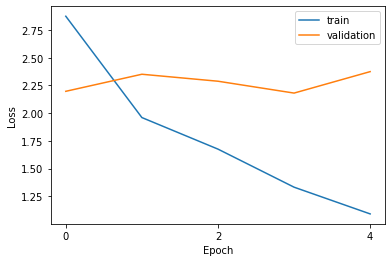

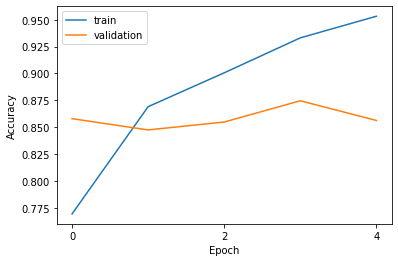

Evaluating model on test set
Loading best weights


100%|██████████| 1941/1941 [1:15:32<00:00,  2.34s/it]


test_loss: 2.0196, test_avg_precision:0.884


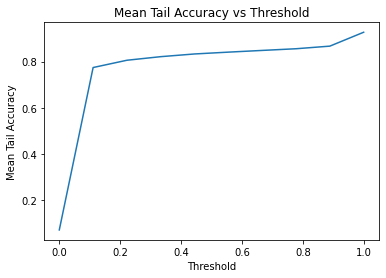

'loss: 2.019641098606818, ap: 5147.141122032987'

In [8]:
def main(data_dir, model_name, num, lr, epochs, batch_size = 16, download_data = False, save_main_results=False):
    """
    Main function
    
    Args:
        data_dir: directory to download Pascal VOC data
        model_name: resnet18, resnet34 or resnet50
        num: model_num for file management purposes (can be any postive integer. Your results stored will have this number as suffix)
        lr: initial learning rate list [lr for resnet_backbone, lr for resnet_fc] 
        epochs: number of training epochs
        batch_size: batch size. Default=16
        download_data: Boolean. If true will download the entire 2012 pascal VOC data as tar to the specified data_dir.
        Set this to True only the first time you run it, and then set to False. Default False 
        save_results: Store results (boolean). Default False
        
    Returns:
        test-time loss and average precision
        
    Example way of running this function:
        if __name__ == '__main__':
            main('../data/', "resnet34", num=1, lr = [1.5e-4, 5e-2], epochs = 15, batch_size=16, download_data=False, save_results=True)
    """
    
    model_dir = os.path.join("/content/gdrive/My Drive/pascal12/models", model_name)
    
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir) 
    
    model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    }
    
    model_collections_dict = {
            "resnet18": models.resnet18(pretrained = True),
            "resnet34": models.resnet34(pretrained = True),
            "resnet50": models.resnet50(pretrained = True)
            }
    
    # Initialize cuda parameters
    use_cuda = torch.cuda.is_available()
    np.random.seed(2019)
    torch.manual_seed(2019)
    device = torch.device("cuda" if use_cuda else "cpu")
    
    print("Available device = ", device)
    model = model_collections_dict[model_name]
    model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
    model.load_state_dict(model_zoo.load_url(model_urls[model_name]))
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 20)
    model.to(device)
           
    optimizer = optim.SGD([   
            {'params': list(model.parameters())[:-1], 'lr': lr[0], 'momentum': 0.9},
            {'params': list(model.parameters())[-1], 'lr': lr[1], 'momentum': 0.9}
            ])
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)
    
    # Imagnet values
    mean=[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
    std=[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]
    
    transformations = transforms.Compose([transforms.Resize((300, 300)),                                 
                                          transforms.RandomChoice([
                                          transforms.ColorJitter(brightness=(0.80, 1.20)),
                                          transforms.RandomGrayscale(p = 0.25)
                                          ]),
                                      transforms.RandomHorizontalFlip(p = 0.25),
                                      transforms.RandomRotation(25),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean = mean, std = std),
                                      ])
        
    transformations_valid = transforms.Compose([transforms.Resize(330), 
                                          transforms.CenterCrop(300), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean = mean, std = std),
                                          ])

    # Create train dataloader
    dataset_train = PascalVOC_Dataset(data_dir,
                                      year='2012', 
                                      image_set='train', 
                                      download=download_data, 
                                      transform=transformations, 
                                      target_transform=encode_labels)
    
    train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=2, shuffle = False ) #shuffle=True)
    
    # Create validation dataloader
    dataset_valid = PascalVOC_Dataset(data_dir,
                                      year='2012', 
                                      image_set='val', 
                                      download=download_data, 
                                      transform=transformations_valid, 
                                      target_transform=encode_labels)
    
    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, num_workers = 2)
    
    # Load the best weights before testing
    weights_file_path =  os.path.join(model_dir, "model-{}.pth".format(num))

    if os.path.isfile(weights_file_path):
        print("Loading best weights")
        if not torch.cuda.is_available():
          model.load_state_dict(torch.load(weights_file_path, map_location=torch.device('cpu')))
        else:
          model.load_state_dict(torch.load(weights_file_path))
    
    log_file = open(os.path.join(model_dir, "log-{}.txt".format(num)), "w+")
    log_file.write("----------Experiment {} - {}-----------\n".format(num, model_name))
    log_file.write("transformations == {}\n".format(transformations.__str__()))
    trn_hist, val_hist = train_model(model, device, optimizer, scheduler, train_loader, valid_loader, model_dir, num, epochs, log_file)
    torch.cuda.empty_cache()
    
    plot_history(trn_hist[0], val_hist[0], "Loss", os.path.join(model_dir, "loss-{}".format(num)))
    plot_history(trn_hist[1], val_hist[1], "Accuracy", os.path.join(model_dir, "accuracy-{}".format(num)))    
    log_file.close()
    
    #---------------Test your model here---------------------------------------
    # Load the best weights before testing
    print("Evaluating model on test set")
    print("Loading best weights")
   
    model.load_state_dict(torch.load(weights_file_path))
    transformations_test = transforms.Compose([transforms.Resize(330), 
                                          transforms.FiveCrop(300), 
                                          transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                          transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean = mean, std = std)(crop) for crop in crops])),
                                          ])
    
    
    dataset_test = PascalVOC_Dataset(data_dir,
                                      year='2012', 
                                      image_set='val', 
                                      download=download_data, 
                                      transform=transformations_test, 
                                      target_transform=encode_labels)
    
    
    test_loader = DataLoader(dataset_test, batch_size = int(batch_size/5), num_workers=0, shuffle=False)
    
    if save_main_results:

        loss, ap, scores, gt = test(model, device, test_loader, returnAllScores=True)
        
        gt_path, scores_path, scores_with_gt_path = ( os.path.join(model_dir, "gt-{}.csv".format(num)), os.path.join(model_dir, "scores-{}.csv".format(num)), os.path.join(model_dir, "scores_wth_gt-{}.csv".format(num)) )
        
        save_results(test_loader.dataset.images, gt, object_categories, gt_path)

        save_results(test_loader.dataset.images, scores, object_categories, scores_path)

        append_gt(gt_path, scores_path, scores_with_gt_path)

        get_classification_accuracy(gt_path, scores_path, os.path.join(model_dir, "clf_vs_threshold-{}.png".format(num)))
        
        return "loss: {}, ap: {}".format(loss , ap)
    
    else:
        loss, ap = test(model, device, test_loader, returnAllScores = False)
        
        return "loss: {}, ap: {}".format(loss , ap)

main('/content/gdrive/My Drive/pascal12/data/', "resnet18", num=2, lr = [1.5e-4, 5e-2], 
     epochs = 5, batch_size=16, download_data=False, save_main_results=True)

## Results
For each of the twenty object classes, we predict the presence/absence of at least one object of that class in a test image. The output is 
a real-valued confidence of the object’s presence. Greater confidence values signify greater confidence that the image contains
an object of the class of interest.


### Mean Tail Accuracy vs Classification Thresholds
The graph below shows the variation of mean tail accuracies against classification thresholds for the entire validation dataset for 20 equally spaced threshold values from 0 to 1.0.

For the first training

accuracy-1.png		gt-1.csv   loss-1.png	scores-1.csv
accuracy-2.png		gt-2.csv   loss-2.png	scores-2.csv
clf_vs_threshold-1.png	log-1.txt  model-1.pth	scores_wth_gt-1.csv
clf_vs_threshold-2.png	log-2.txt  model-2.pth	scores_wth_gt-2.csv


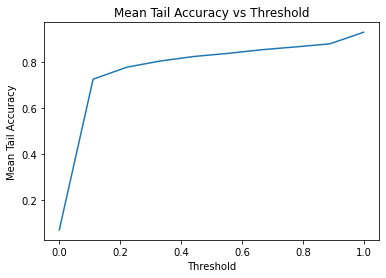

In [9]:
!ls    "/content/gdrive/My Drive/pascal12/models/resnet18"
num = 1
model_dir = '/content/gdrive/My Drive/pascal12/models/resnet18/'
gt_path = os.path.join(model_dir, "gt-{}.csv".format(num))
scores_path = os.path.join(model_dir, "scores-{}.csv".format(num))
scores_with_gt_path = os.path.join(model_dir, "scores_wth_gt-{}.csv".format(num)) 

if  os.path.isfile(gt_path) and os.path.isfile(scores_path):
  get_classification_accuracy(gt_path, scores_path, os.path.join(model_dir, "clf_vs_threshold-{}.png".format(num)))

In [10]:
if os.path.isfile(gt_path):
  ground_truth_data = pd.read_csv(gt_path)

In the table below, the ground truth data is shown. For example, in the second row, the precision value for Person and train is 1, which shows that only Person and Train are present in the second image.

In [11]:
ground_truth_data.head()

,image,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
if os.path.isfile(scores_path):
  images_scores = pd.read_csv(scores_path)

In the table below, our prediction result table is shown. For example, in the second row, the precision values for Person and train are 0.348221 and 0.610965 respectively which are higher than others, which signify greater confidence that the image contains Person and train.

In [13]:
images_scores.head()

,image,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.009287,0.003219,0.002313,0.003254,0.009370,0.003594,0.014203,0.029917,0.071104,...,0.017600,0.000771,0.001337,0.001996,0.114636,0.003104,0.002262,0.009461,0.020533,0.055712
1,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.000858,0.024758,0.007302,0.008745,0.012141,0.039327,0.027585,0.011330,0.117427,...,0.025570,0.008641,0.006592,0.005312,0.348221,0.020615,0.019515,0.030677,0.610965,0.023551
2,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.003742,0.001234,0.000869,0.614426,0.012050,0.014435,0.022438,0.003562,0.085832,...,0.066205,0.002542,0.003702,0.001551,0.610446,0.006537,0.000737,0.005008,0.066454,0.003911
3,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.006069,0.041863,0.001381,0.019433,0.002385,0.002877,0.082141,0.000156,0.020875,...,0.006946,0.000252,0.341310,0.001392,0.168436,0.003681,0.616514,0.000637,0.007450,0.000022
4,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.007584,0.032795,0.002286,0.001732,0.008411,0.001840,0.009195,0.014039,0.548136,...,0.048582,0.000565,0.000783,0.001216,0.026173,0.008246,0.000618,0.012076,0.015400,0.162205


In [14]:
if os.path.isfile(scores_with_gt_path):
  images_scores_gt_data = pd.read_csv(scores_with_gt_path)

We merge the ground truth and our prediction results below to understand the results better

In [15]:
images_scores_gt_data.head()

,image,gt,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['tvmonitor'],0.009287,0.003219,0.002313,0.003254,0.009370,0.003594,0.014203,0.029917,...,0.017600,0.000771,0.001337,0.001996,0.114636,0.003104,0.002262,0.009461,0.020533,0.055712
1,/content/gdrive/My Drive/pascal12/data/VOCdevk...,"['person', 'train']",0.000858,0.024758,0.007302,0.008745,0.012141,0.039327,0.027585,0.011330,...,0.025570,0.008641,0.006592,0.005312,0.348221,0.020615,0.019515,0.030677,0.610965,0.023551
2,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['boat'],0.003742,0.001234,0.000869,0.614426,0.012050,0.014435,0.022438,0.003562,...,0.066205,0.002542,0.003702,0.001551,0.610446,0.006537,0.000737,0.005008,0.066454,0.003911
3,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['cow'],0.006069,0.041863,0.001381,0.019433,0.002385,0.002877,0.082141,0.000156,...,0.006946,0.000252,0.341310,0.001392,0.168436,0.003681,0.616514,0.000637,0.007450,0.000022
4,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['tvmonitor'],0.007584,0.032795,0.002286,0.001732,0.008411,0.001840,0.009195,0.014039,...,0.048582,0.000565,0.000783,0.001216,0.026173,0.008246,0.000618,0.012076,0.015400,0.162205


### Mean Tail Accuracy vs Classification Thresholds
The graph below shows the variation of mean tail accuracies against classification thresholds for the entire validation dataset for 20 equally spaced threshold values from 0 to 1.0.

For the second training

accuracy-1.png		gt-1.csv   loss-1.png	scores-1.csv
accuracy-2.png		gt-2.csv   loss-2.png	scores-2.csv
clf_vs_threshold-1.png	log-1.txt  model-1.pth	scores_wth_gt-1.csv
clf_vs_threshold-2.png	log-2.txt  model-2.pth	scores_wth_gt-2.csv


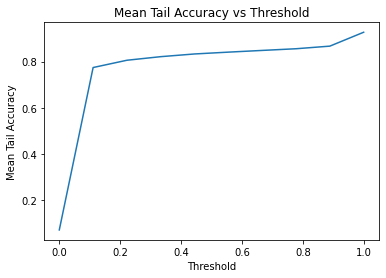

In [18]:
!ls    "/content/gdrive/My Drive/pascal12/models/resnet18"
num = 2
model_dir = '/content/gdrive/My Drive/pascal12/models/resnet18/'
gt_path = os.path.join(model_dir, "gt-{}.csv".format(num))
scores_path = os.path.join(model_dir, "scores-{}.csv".format(num))
scores_with_gt_path = os.path.join(model_dir, "scores_wth_gt-{}.csv".format(num)) 

if  os.path.isfile(gt_path) and os.path.isfile(scores_path):
  get_classification_accuracy(gt_path, scores_path, os.path.join(model_dir, "clf_vs_threshold-{}.png".format(num)))

In [21]:
if os.path.isfile(scores_path):
  images_scores = pd.read_csv(scores_path)

In the table below, our prediction result table is shown. For example, in the second row, the precision values for Person and train are 0.076891 and 0.386247 respectively which are higher than others, which signify greater confidence that the image contains Person and train.

In [22]:
images_scores.head()

,image,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.035217,0.000302,0.000091,0.000147,0.002010,0.000176,0.001691,0.064837,0.010165,...,0.001215,0.000040,0.001190,0.000085,0.008483,0.001438,0.000377,0.000354,0.000207,0.759786
1,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.001442,0.002717,0.012309,0.004311,0.007099,0.005531,0.002117,0.006788,0.013524,...,0.001547,0.000804,0.000890,0.000608,0.076891,0.002904,0.002707,0.006205,0.386247,0.021042
2,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.095955,0.000409,0.002325,0.932201,0.248752,0.000407,0.000133,0.000423,0.000941,...,0.010096,0.000210,0.000191,0.000079,0.059656,0.000325,0.000248,0.000285,0.000951,0.001971
3,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.003409,0.005394,0.000893,0.007149,0.001195,0.001647,0.012040,0.000186,0.000742,...,0.000257,0.000076,0.087880,0.000375,0.043502,0.000483,0.033752,0.000084,0.001324,0.000017
4,/content/gdrive/My Drive/pascal12/data/VOCdevk...,0.001302,0.007706,0.003860,0.000086,0.011575,0.001720,0.001480,0.015788,0.221611,...,0.005587,0.000735,0.000393,0.000473,0.008812,0.004615,0.000053,0.001054,0.001061,0.980379


In [23]:
if os.path.isfile(scores_with_gt_path):
  images_scores_gt_data = pd.read_csv(scores_with_gt_path)

In [24]:
images_scores_gt_data.head()

,image,gt,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['tvmonitor'],0.035217,0.000302,0.000091,0.000147,0.002010,0.000176,0.001691,0.064837,...,0.001215,0.000040,0.001190,0.000085,0.008483,0.001438,0.000377,0.000354,0.000207,0.759786
1,/content/gdrive/My Drive/pascal12/data/VOCdevk...,"['person', 'train']",0.001442,0.002717,0.012309,0.004311,0.007099,0.005531,0.002117,0.006788,...,0.001547,0.000804,0.000890,0.000608,0.076891,0.002904,0.002707,0.006205,0.386247,0.021042
2,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['boat'],0.095955,0.000409,0.002325,0.932201,0.248752,0.000407,0.000133,0.000423,...,0.010096,0.000210,0.000191,0.000079,0.059656,0.000325,0.000248,0.000285,0.000951,0.001971
3,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['cow'],0.003409,0.005394,0.000893,0.007149,0.001195,0.001647,0.012040,0.000186,...,0.000257,0.000076,0.087880,0.000375,0.043502,0.000483,0.033752,0.000084,0.001324,0.000017
4,/content/gdrive/My Drive/pascal12/data/VOCdevk...,['tvmonitor'],0.001302,0.007706,0.003860,0.000086,0.011575,0.001720,0.001480,0.015788,...,0.005587,0.000735,0.000393,0.000473,0.008812,0.004615,0.000053,0.001054,0.001061,0.980379
